# Tweet sentiment classifier

The purpose of this project was to gain some experience using fast.ai, this is my first attempt at creating a text classifier. I am using the [sentiment140](https://www.kaggle.com/kazanova/sentiment140) data set. For more information see fast.ai lessons: 4 [here](https://course.fast.ai/). This [post](https://mc.ai/text-classification%E2%80%8A-%E2%80%8Atwitter-sentiment-analysis/) also helped me to create the classifier.

In [4]:
from fastai.text import *

In [68]:
path = Path('data/freid-text')

## Generate dataset

### From csv

Upload your csv to the path directory and reference it's location below. Also, specify the encoding and name of each column.

In [14]:
encoding = 'ISO-8859-1'
col_names = ['target', 'id', 'date', 'flag', 'user', 'text']

data_set = Path(path/'training.1600000.processed.noemoticon.csv')

Next, read the csv and examing the first few rows.

In [15]:
data = pd.read_csv(data_set, encoding=encoding, low_memory=False, names=col_names)

In [16]:
data.head(2)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


For the sentiment140 data set, the target column classifies the sentiment of the tweet. 0 is negative and 4 is positive. We are only intreseted in the sentiment and content of a tweet. Lets isolated both of these columns and assigned them to new variables. The sentiment140 data set contains millions of tweets. To experiment more quickly lets just use a random 100,000 tweets from the dataset.

In [17]:
table = data.copy().sample(100000, random_state=42)
table = table[['target', 'text']]
table.dropna(inplace=True)
table[1:4]

,target,text
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...


Finally, create a databunch:

In [96]:
data_lm = (TextList.from_df(table, cols='text')
 .split_by_rand_pct(0.1)
 .label_for_lm()
 .databunch())

data_lm.show_batch()

idx,text
0,there to revise ! * xxmaj stupid xxmaj school * :'( xxbos upper airways problem xxbos xxmaj going to miss xxmaj pastor 's sermon on xxmaj faith ... xxbos on lunch xxrep 4 . dj should come eat with me xxbos @piginthepoke oh why are you feeling like that ? xxbos gahh xxunk needs to xxunk is horrible xxbos xxunk thank you glad you like it ! xxmaj there is
1,". on it and xxmaj dr said i tore 2 xxunk in my ankle xxbos xxunk xxmaj happy xxmaj birthday ! xxbos xxunk ugh ! xxmaj give me a shout out that 'll make it better xoxo xxmaj lena xxbos xxmaj mornig twitterland ! uploading pics , need to go to school xxbos xxunk are having a country - wide party today ... it 's so awesome xxbos xxunk i"
2,"handed xxbos a new xxup psp ! xxmaj so want http : / / tinyurl.com / xxunk xxbos xxunk _ how was it last night ? xxbos xxunk i agree with xxunk i do nt honestly know what we would do without your awesomeness being around . xxbos i think my elbow is xxunk ? xxbos xxmaj morning xxunk ! i ca n't feel my nose , my hand and"
3,"xxmaj ewww .. just drank a xxmaj coors xxmaj light , concert over , now xxmaj tony is gon na take me home feel bad cause i 'm the only looser not goin to the afterparty xxbos @papareboy dude , how is xxunk and xxunk making out xxup bad ! ? ! i xxup would xxup buy xxup tickets xxup for xxup that ! xxbos xxunk on here but they"
4,"hangover .. really inspirational material there xxmaj in all xxunk though , it was pretty funny ! xxmaj almost as good as xxmaj xxunk ! xxbos xxunk a xxrep 4 w i know how you feel , hopefully you 'll come up with something even better than before . xxbos stay positive y all . xxmaj tomorrow is a new day xxbos xxmaj what a fun night xxbos i 'm"


Each sentence is split into tokens. Each token is then extracted from the text and converted into integers. It is placed into a list called vocab which contains all the words used in the dataset. The correspondance between the tokens and integers is stored in a dictionary called itos in the vocab attribute of the dataset.

In [19]:
data_lm.vocab.itos[:5]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld']

## Training the language model

Before the model is able to classify the tweets’ sentiment, it has to be able to understand English. In order to do so, I am use the pre-trained model WT103_FWD. This language model was trained on the Wikitext 103 dataset created by Stephen Merity and is able to predict the next word in significant sized Wikipedia articles. Note that language models can use a lot of GPU, so make sure you have set a appropriate batch size.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


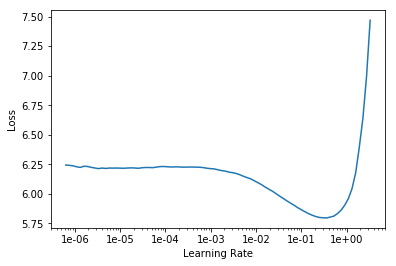

In [46]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=URLs.WT103_FWD, drop_mult=0.5)

learn.lr_find()
learn.recorder.plot()

Set lr to the "Learning Rate" where "Loss" has the steepest descent.

In [48]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.512846,4.307630,0.230734,01:40


In [101]:
learn.save('fit_head')

In [102]:
learn.unfreeze()

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [54]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.242942,4.178839,0.248974,02:09
1,4.137140,4.096766,0.252280,02:09
2,4.052454,4.048640,0.261581,02:09
3,3.920583,4.016871,0.265758,02:09
4,3.776951,4.012823,0.266858,02:09
5,3.640837,4.025111,0.266502,02:09
6,3.520312,4.053202,0.264445,02:09
7,3.409224,4.078838,0.263892,02:09
8,3.345428,4.096138,0.263430,02:09
9,3.303437,4.106428,0.263132,02:09


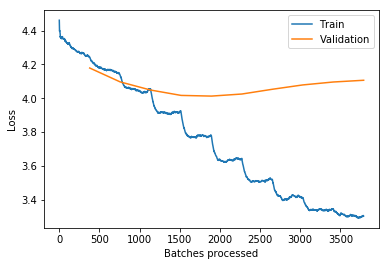

In [55]:
learn.recorder.plot_losses()

In [56]:
learn.show_results()

text,target,pred
xxbos xxmaj hello to all new followers from warm and sunny xxmaj tokyo ! xxbos xxmaj just xxmaj xxunk xxmaj,my t - shirt from xxunk is on its way http : / / tinyurl.com / xxunk xxbos xxunk xxunk,xxunk xxmaj - shirt from xxmaj 's a my way to : / / bit.ly / xxunk xxbos xxunk xxmaj
"for pretty dresses , short xxunk , tanks , shorts and sandals . xxbos xxmaj just got my ass kicked",by a xxunk chair that fell on me while i was sitting on the floor but kinda lol xxbos xxmaj,by the xxunk . . was on me and i was walking inside the floor . i xxunk xxbos xxunk
"xxunk , but i feel that this is very important ... xxbos xxunk i know how it feels and i",know it sucks . i 'm sorry . * huggles * xxbos xxunk had xxunk wings today and i thought,'m it 's xxbos xxbos 'm so xxbos xxbos hugs * xxbos xxunk xxmaj a xxunk last ! was 'm
meet tomorrow that wo n't end til then . xxunk xxbos xxunk holy cow batman ... you have over 200,followers . i 'm not even at 150 yet xxmaj you rock ! xxbos xxunk thx xxunk xxbos xxunk i,+ xxbos xxmaj 'm sure sure sure the followers . what can ! xxbos xxunk xxmaj for ! xxunk xxmaj
were n't as good as i thought they would be now i know why i do n't eat mexican xxbos,"xxmaj happy sunday ! just woke up a xxrep 7 h xxbos xxunk yeah , that s what i thought",xxunk just xxmaj everyone xxmaj got up and little 4 w ! xxunk xxmaj i i 's what i said


In [57]:
learn.save('fine-tuned')

In [58]:
learn.load('fine-tuned');

Now, lets check our model and see what it predicts after a few given words.

In [66]:
TEXT = "Nice"
N_WORDS = 40
N_SENTENCES = 1

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Nice weather in Perth Garden ! Pineapple Express xxbos Tired . Working on a paper on London is going to be a really boring day tomorrow xxbos Thank you for your support ,


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [67]:
learn.save_encoder('fine-tuned-enc')

## Train model 

Our model now had a better understanding of English. Lets now train our text classifier. But specified the model to use the vocab created by the LM, otherwise the encoder would be meaningless.

In [69]:
data_class = (TextList.from_df(table, cols='text', vocab=data_lm.vocab)
 .split_by_rand_pct(0.2)
 .label_from_df('target')
 .databunch(bs=24))

data_class.show_batch(1)

text,target
xxbos xxunk xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it,4


In [70]:
learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine-tuned-enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


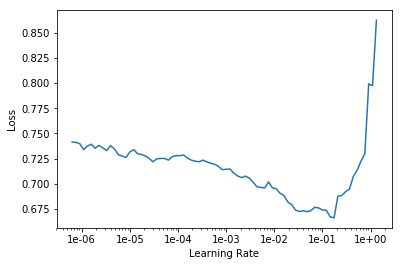

In [72]:
learn.lr_find()
learn.recorder.plot()

Set lr to the "Learning Rate" where "Loss" has the steepest descent.

In [73]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.512524,0.475446,0.770850,01:40


In [74]:
learn.save('stage-1')

In [75]:
learn.unfreeze()

In [76]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.472738,0.410391,0.808950,01:57


In [77]:
learn.save('stage-2')

In [78]:
learn.unfreeze()

In [79]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.432595,0.395549,0.817550,03:01


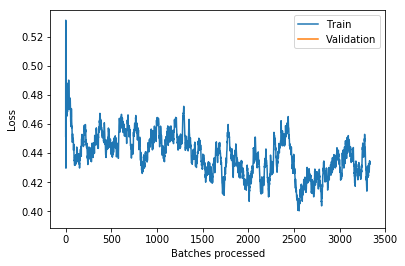

In [80]:
learn.recorder.plot_losses()

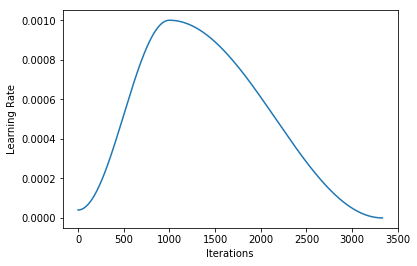

In [81]:
learn.recorder.plot_lr()

In [82]:
learn.show_results()

text,target,prediction
xxbos yay ! ! ! i xxup got xxup xxunk xxup of xxup the xxup week xxup and i xxup never xxup get xxup it ... xxup hehe xxup no xxup skool xxup on xxup monday xxup no xxup more xxup evil xxup science xxup teacher xxup yay xxup yay xxup yay xxup oh xxup no i xxup hav xxup exams,0,0
xxbos # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day # seb - day,4,4
"xxbos xxup my xxup twiggas ! ! ! xxup we xxup done , xxup done xxup it , xxup again . xxup we @ 152 xxup ya xxup dig . xxup i'm xxup proud xxup of xxup my xxup xxunk 4 xxup holdin xxup it xxup down 4 xxup me xxup today . xxup much xxup luv + xxup appreciation .",4,4
xxbos ? ? - ? ? xxrep 8 ? xxrep 6 ? ? xxmaj ride xxmaj town xxrep 11 ? xxrep 6 ? ? ? xxrep 4 ? . ? xxrep 6 ? ? xxrep 6 ? & ' xxrep 8 ? xxrep 4 ? & ' - xxrep 8 ? xxrep 10 ? xxrep 9 ? ? ? ?,4,4
xxbos xxup my xxup mom xxup never xxup came xxup home xxup and xxup called xxup realy xxup early xxup but i xxup was a xxup sleep xxup and xxup now xxup she xxup wont xxup answer xxup the xxup phone xxup and xxup she xxup is xxup not xxup at xxup work i xxup am xxup scared !,0,0


In [83]:
learn.save('stage-3')

In [84]:
learn.unfreeze()

## Save & export model

Saves ```.pth``` file in: ```/models``` and exports ```.pkl``` file in: ```/path```

In [85]:
learn.save("stage-4")

In [93]:
learn.export(path/"tweet-sentiment.pkl")

## Make prediction

In [87]:
learn.predict("I definitely recommend that!")

(Category 4, tensor(1), tensor([0.0566, 0.9434]))

In [88]:
learn.predict("I really didn't like that!")

(Category 0, tensor(0), tensor([0.7798, 0.2202]))